# Probability distributions in HIC experiments

We study the relationship between two contigs in a HIC experiments - contig 1 and contig 2, with size $S_1$ and $S_2$, respectively. Our goal is to find out the probability distribution for the number of links between these two contigs, given their distance $D$. We can then compare against the observed number of links to try to infer if the two contigs are linked or not.

This distribution is used in the `partition` procedure in [ALLHIC](https://github.com/tanghaibao/allhic). If the two contigs are considered close enough, e.g. $\Pr(D < threshold) > 0.5$, then we infer the two contigs to be linked. This link graph is then partitioned and distinct partition are then solved independently.

We use the following notations:
- $S_1$, $S_2$: size of contigs 1 and 2.
- $x_1$, $x_2$: start coordinates of contigs 1 and 2. Without loss of generality, we let $x_1 = 0$ and $x_2 > S_1$.
- $D$: inner distance between contigs 1 and 2. We require $D > 0$. By definition, we have $x_1 + S_1 + D = x_2$.

We build our models based on continuous distributions due to the large size of genomic positions. For each paired reads, we first sample the starting position $x$ uniformly on contig 1, that follows a uniform distribution:

$$f(x) = \begin{cases}
            \frac{1}{S_1}, & 0 \leq x \leq S_1 \\
            0, & \text{otherwise}
         \end{cases}
$$

We then consider the length $y$ of this link, that follows a [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution):

$$g(y) = \begin{cases}
            \frac{{\alpha} y_m^{\alpha}}{y^{\alpha + 1}}, & y \geq y_m \\
            0, & y < y_m
         \end{cases}
$$

Where $y_m$ is the smallest observed link length in the dataset. As a side note, we can use the set of intra-contig links to infer the MLE $\hat{\alpha}$, using the formula below.

$$\hat{\alpha} = \frac{n}{\sum_{i=1}^{n} \ln{y_i} - n\ln{y_m}}
$$

Now let's come back to the problem of trying to infer the ending position $z$ of the read pair, which is the sum of two random variable $Z = X + Y$. Then $z$ is a convolution of two probability distribution - uniform and Pareto.

$$h(z) = \int_{-\infty}^{\infty} f(x) \cdot g(z - x) dx
$$

In order to make $f(x)$ nonzero, we need $0 \leq x \leq S_1$. In order to make $g(z - x)$ nonzero, we need $z - x \geq y_m$, borrowing idea from [here](https://math.stackexchange.com/questions/357672/density-of-sum-of-two-uniform-random-variables-0-1), or $x \leq z - y_m$. Therefore, by comparing $z - y_m$ and $S_1$, we then break this down into two cases:

$$h(z) = \begin{cases}
            \frac{{\alpha} y_m^{\alpha}}{S_1} \int_{0}^{z - y_m} \frac{1}{(z - x)^{\alpha + 1}} dx, & y_m \leq z \leq S_1 + y_m \\
            \frac{{\alpha} y_m^{\alpha}}{S_1} \int_{0}^{S_1} \frac{1}{(z - x)^{\alpha + 1}} dx, & z > S_1 + y_m \\
            0, & \text{otherwise}
         \end{cases}
$$

Taking the integral and simplify the formula to closed form:

$$h(z) = \begin{cases}
            \frac{1}{S_1} \cdot [1 - (\frac{y_m}{z})^{\alpha}], & y_m \leq z \leq S_1 + y_m \\
            \frac{1}{S_1} \cdot [(\frac{y_m}{z - S_1})^{\alpha} - (\frac{y_m}{z})^{\alpha}], & z > S_1 + y_m \\
            0, & \text{otherwise}
         \end{cases}
$$


Let's take a look at the shape of this distribution.

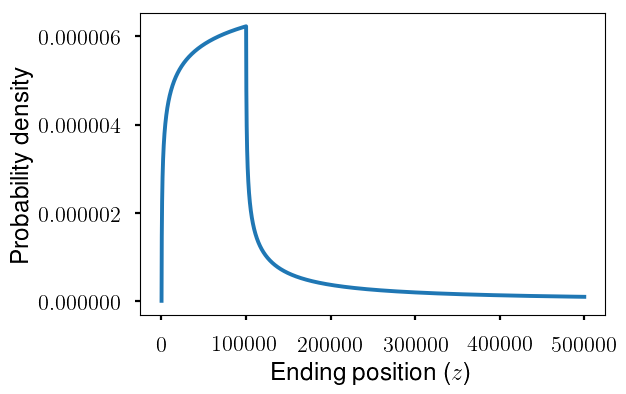

In [1]:
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

ym = 150.
S1 = 100000.
alpha = .15   # Roughly 1 / [log(100000) - log(150)]

def h(z):
    if ym <= z <= S1 + ym:
        return 1 / S1 * (1 - (ym / z) ** alpha)
    if z > S1 + ym:
        return 1 / S1 * ((ym / (z - S1)) ** alpha - (ym / z) ** alpha)
    
x = np.arange(ym + 1, 500000)
y = np.array([h(z) for z in x])
plt.plot(x, y)
ax = plt.gca()
ax.set_xlabel("Ending position ($z$)")
ax.set_ylabel("Probability density")

## Probability distribution for link length distribution

For this experiment, we use real data from a draft rice genome and hope to get the best distribution that can quantify the data. Possible candidates are:

- Exponential distribution
- Bounded reciprocal distribution
- Pareto distribution
- Bounded Pareto distribution 

In [23]:
fp = open("../tests/Chr1/outer.dis.txt")
dists = []
for row in fp:
    contigname, links = row.split()
    links = [int(x) for x in links.strip().strip(",").split(",")]
    dists.extend(links)

threshold = 1000
dists = np.array(dists)
dists = dists[dists > threshold]
print("A total of {} links found (threshold={})".format(len(dists), threshold))

A total of 23826 links found (threshold=1000)


DescribeResult(nobs=23826, minmax=(1001, 331642), mean=26707.098421892049, variance=1035824816.9940064, skewness=2.3206046836564607, kurtosis=7.156349912657369)


(0, 100000)

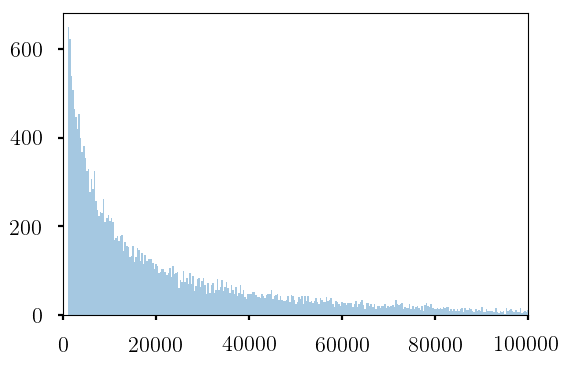

In [26]:
from scipy import stats

print(stats.describe(dists))
logdists = np.log(dists)
ax = sns.distplot(dists, bins=1000, kde=False)
ax.set_xlim(0, 100000)

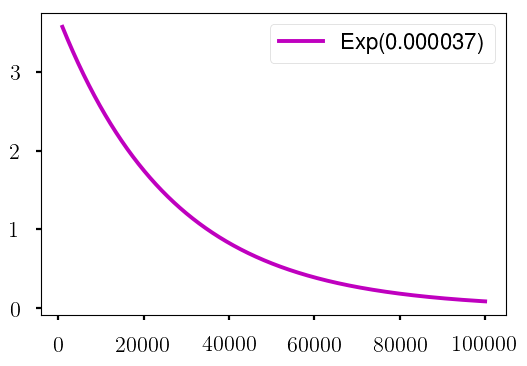

In [43]:
# Exponential
lambda_hat = 1 / np.mean(dists)
ymm = dists.min()

def exponential_pdf(t, L):
    """ Returns pdf for exponential distribution
    """
    return L * np.exp(-L * t);

t = np.arange(ymm, 100000)
line, = plt.plot(t, exponential_pdf(t, lambda_hat) * (100000 - ymm), "m-")
line.set_label('Exp({:.6f})'.format(lambda_hat))
plt.gca().legend()

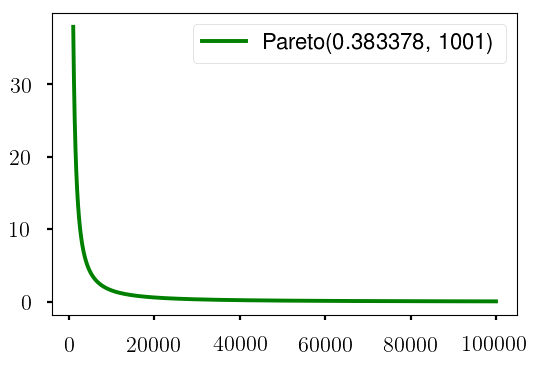

In [41]:
# Pareto
import math

ymm = dists.min()
alpha_hat = len(dists) / (np.log(dists).sum() - len(dists) * math.log(ymm))

def pareto_pdf(t, alpha, ymm):
    """ Returns pdf for Pareto distribution
    """
    return alpha * ymm ** alpha / t ** (alpha + 1)

t = np.arange(ymm, 100000)
line, = plt.plot(t, pareto_pdf(t, alpha_hat, ymm) * (100000 - ymm), "g-")
line.set_label('Pareto({:.6f}, {})'.format(alpha_hat, ymm))
plt.gca().legend()

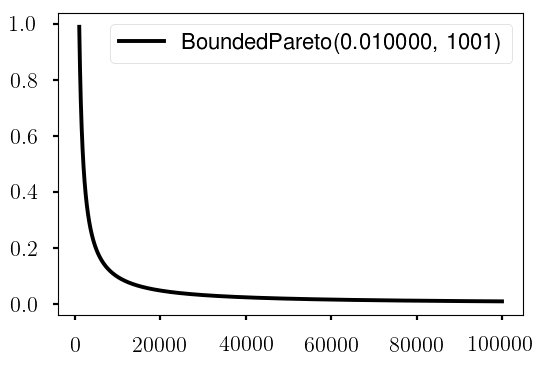

In [53]:
# Bounded Pareto
import math

ymm = dists.min()
yma = dists.max()
alpha_hat = .01

def bounded_pareto_pdf(t, alpha, ymm, yma):
    """ Returns pdf for Pareto distribution
    """
    return (alpha * ymm ** alpha / t ** (alpha + 1)) / (1 - (ymm / yma) ** alpha)

t = np.arange(ymm, 100000)
line, = plt.plot(t, bounded_pareto_pdf(t, alpha_hat, ymm, yma) * (100000 - ymm), "k-")
line.set_label('BoundedPareto({:.6f}, {})'.format(alpha_hat, ymm))
plt.gca().legend()

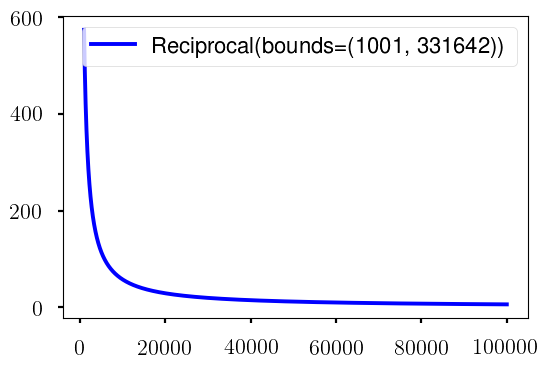

In [42]:
# Reciprocal

ymm = dists.min()
yma = dists.max()

def reciprocal_pdf(t, ymm, yma):
    """ Reciproal pdf, there is no param other than the two bounds
    """
    return (math.log(yma) - math.log(ymm)) / t

t = np.arange(ymm, 100000)
line, = plt.plot(t, reciprocal_pdf(t, ymm, yma) * (100000 - ymm), "b-")
line.set_label('Reciprocal(bounds=({}, {}))'.format(ymm, yma))
plt.gca().legend()

gamma (0.64611813470920598, 1000.9999999999998, 38768.295246559253)
beta (0.69237522949105568, 70.509230067608172, 1000.9999999999999, 2635333.6911181072)
rayleigh (-19285.689596631833, 39693.310445647658)
norm (26707.098421892049, 32183.557019634838)
pareto (0.38354712996229379, -1.3001017132177295, 1002.3001016048311)


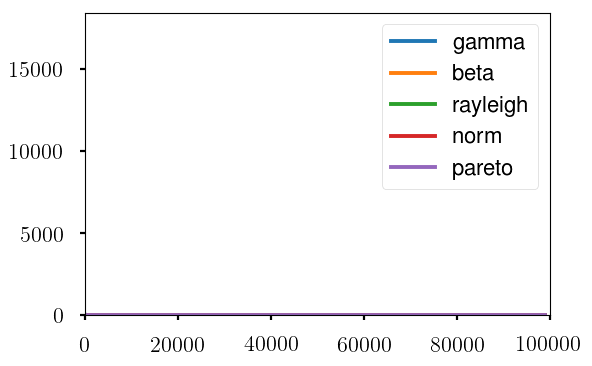

In [40]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats

a, b = ymm, 100000
size = b - a
x = scipy.arange(a, b)
y = dists
h = plt.hist(y, color='w')

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    print dist_name, param
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0, b)
plt.legend(loc='upper right')
plt.show()

## Probability of an inter-contig link fall within contig 2

From the $h(z)$ distribution, we are mostly interested in the second case, when the ending position occurs after contig i.e. $z > S_1$, beyond the extent of contig 1, so that it becomes a inter-contig link, rather than intra-contig link. The integral when $z > S_1$ is the following:

$$\Pr(z > S_1) = 1 - \Pr(z \leq S_1) = 1 - \frac{1}{S_1} \int_{y_m}^{S_1} 1 - (\frac{y}{z})^{\alpha} dz 
                = \frac{S_1 (\frac{y_m}{S_1})^{\alpha} - \alpha y_m}{S_1 (1 - \alpha)}
$$

In [2]:
(S1 * (ym / S1) ** alpha - alpha * ym) / (S1 * (1 - alpha))

0.44333858891237005

This is just a normalizing constant $C$.

(0, 10000)

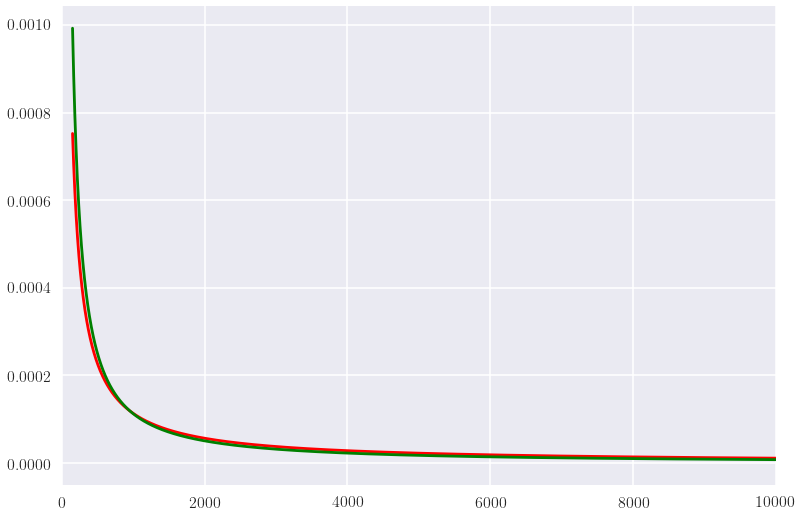

In [6]:
import math

C = (math.log(1000000) - math.log(ym))

def reciprocal(z):
    return 1 / (z * C)

def pareto(z):
    return alpha * ym ** alpha / z ** (alpha + 1)


y1 = np.array([reciprocal(z) for z in x])
y2 = np.array([pareto(z) for z in x])
plt.plot(x, y1, 'r-')
plt.plot(x, y2, 'g-')
ax = plt.gca()
ax.set_xlim(0, 10000)